<a href="https://colab.research.google.com/github/cvaranasi1/NeuralNetworks_in_TensorFlow/blob/master/Week2_Course3_Exercise_Text_Classification_BBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [196]:
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

In [197]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-09-24 02:07:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 74.125.134.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.04s   

2020-09-24 02:07:39 (112 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [198]:
vocab_size = 10000
embedding_dim = 16
max_length = 128
trunc_type = 'post'
padding_type = 'pre'
oov_tok = "<OOV>"
training_portion = .8

In [199]:
sentences = []
labels = []
with open('/tmp/bbc-text.csv', 'r') as f: 
  reader = csv.DictReader(f)
  for item in reader:
    labels.append(item['category'])
    sentences.append(item['text'])


In [200]:
# Very careful here. We didn't initialize the 'ts' object with numWords=vocab_size. 
# So, number of entries in 'word_index' could exceed 'vocab_size' in number.
# The correct value should be used in Embedding layer.
ts=Tokenizer()  
tl=Tokenizer()
ts.fit_on_texts(sentences)
tl.fit_on_texts(labels)
wis=ts.word_index
wil=tl.word_index
tokens_s = ts.texts_to_sequences(sentences)
tokens_l = tl.texts_to_sequences(labels)
tokens_s = pad_sequences(tokens_s,maxlen=max_length,padding=padding_type, truncating=trunc_type)
num_train_samples = int(len(tokens_s)*training_portion)
train_s = tokens_s[:num_train_samples]
valid_s = tokens_s[num_train_samples:]
train_l = np.array(tokens_l[:num_train_samples])
valid_l = np.array(tokens_l[num_train_samples:])
num_label_classes = len(wil) + 1
train_l = keras.utils.to_categorical(train_l,num_label_classes)
valid_l = keras.utils.to_categorical(valid_l,num_label_classes)
print(train_s.shape)
print(valid_s.shape)
print(train_l.shape)
print(valid_l.shape)

(1780, 128)
(445, 128)
(1780, 6)
(445, 6)


In [201]:
num_diff_words = len(wis) + 1
print(num_diff_words)

model = Sequential()
model.add(keras.layers.Embedding(input_dim=num_diff_words, output_dim=embedding_dim, input_length=max_length))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(24,activation='relu'))
model.add(keras.layers.Dense(num_label_classes,activation='softmax'))
model.summary()

29727
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 128, 16)           475632    
_________________________________________________________________
global_average_pooling1d_21  (None, 16)                0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_43 (Dense)             (None, 6)                 150       
Total params: 476,190
Trainable params: 476,190
Non-trainable params: 0
_________________________________________________________________


In [202]:
print(train_s.shape)
print(train_l.shape)
print(valid_s.shape)
print(valid_l.shape)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_s, train_l,epochs= 50, validation_data = (valid_s,valid_l))

(1780, 128)
(1780, 6)
(445, 128)
(445, 6)
Epoch 1/50
56/56 [==============================] - 1s 11ms/step - loss: 1.7588 - accuracy: 0.2376 - val_loss: 1.7131 - val_accuracy: 0.3281
Epoch 2/50
56/56 [==============================] - 0s 9ms/step - loss: 1.6487 - accuracy: 0.4444 - val_loss: 1.5724 - val_accuracy: 0.4562
Epoch 3/50
56/56 [==============================] - 0s 8ms/step - loss: 1.4583 - accuracy: 0.4556 - val_loss: 1.3615 - val_accuracy: 0.4652
Epoch 4/50
56/56 [==============================] - 0s 8ms/step - loss: 1.2074 - accuracy: 0.5006 - val_loss: 1.1301 - val_accuracy: 0.5438
Epoch 5/50
56/56 [==============================] - 0s 8ms/step - loss: 0.9678 - accuracy: 0.6287 - val_loss: 0.9394 - val_accuracy: 0.6921
Epoch 6/50
56/56 [==============================] - 0s 9ms/step - loss: 0.7619 - accuracy: 0.8124 - val_loss: 0.7708 - val_accuracy: 0.8517
Epoch 7/50
56/56 [==============================] - 0s 8ms/step - loss: 0.5738 - accuracy: 0.9528 - val_loss: 0.6208 

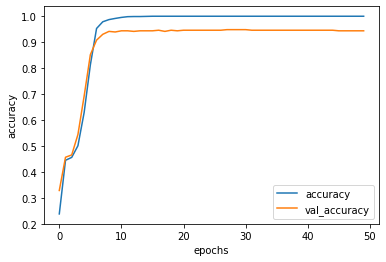

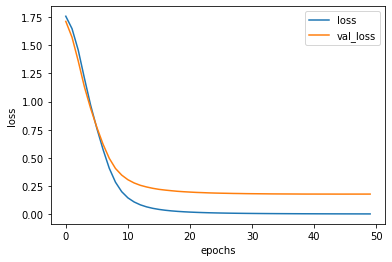

In [203]:
def plot_graph(history,string):
  plt.plot(np.arange(len(history.history[string])),history.history[string])
  plt.plot(np.arange(len(history.history[string])),history.history['val_'+string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graph(history,'accuracy')
plot_graph(history,'loss')


In [213]:
#Write code to store away the Embeddings
import io
import copy
weights=model.layers[0].get_weights()
print(weights[0].shape)
xx = copy.deepcopy(weights[0])
embeddings = io.open('embeddings_week2_NLP.tsv','w',encoding = 'utf-8') # We created an object
words = io.open('words_week2_NLP.tsv','w', encoding ='utf-8')           # We created an object
for k,v in wis.items():
  embeddings.write('\t'.join([str(item) for item in xx[v]]) +'\n')
  words.write(k)
embeddings.close()
words.close()



(29727, 16)


In [214]:
for k,v in wis.items():
  if v<10:
    print((k,v))


('the', 1)
('to', 2)
('of', 3)
('and', 4)
('a', 5)
('in', 6)
('s', 7)
('for', 8)
('is', 9)


In [215]:
try:
  from google.colab import files
except ImportError:
  print("\nCould not import the file\n")
files.download('embeddings_week2_NLP.tsv')
files.download('words_week2_NLP.tsv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>